In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

dhcp-10-31-137-55.dyn.MIT.EDU
/Users/akarshkumar0101/spaghetti/src_pb
/Users/akarshkumar0101/miniconda3/bin/python


In [2]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [3]:
from cppn import CPPN, FlattenCPPNParameters
import util

ModuleNotFoundError: No module named 'evosax'

In [15]:
# 4, 50
cppn = CPPN(10, 25, nonlins="identity,sin,cos,gaussian,sigmoid")
cppn = FlattenCPPNParameters(cppn)

save_dir = "../temp_dir"
losses = util.load_pkl(save_dir, "losses")
imgs_train = util.load_pkl(save_dir, "imgs_train")
params = util.load_pkl(save_dir, "params")

ParameterReshaper: 6028 parameters detected for optimization.


In [16]:
imgs_train.shape, losses.shape

((501, 256, 256, 3), (50000,))

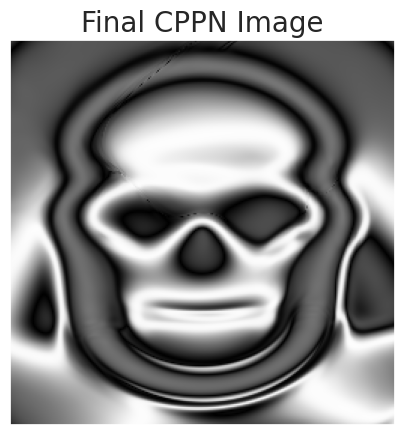

In [17]:
plt.figure(figsize=(5, 5))
img = cppn.generate_image(params)
plt.imshow(img); plt.grid(False); plt.xticks([]); plt.yticks([])
plt.title("Final CPPN Image", fontsize=20)
plt.show()

(512, 2560, 3)


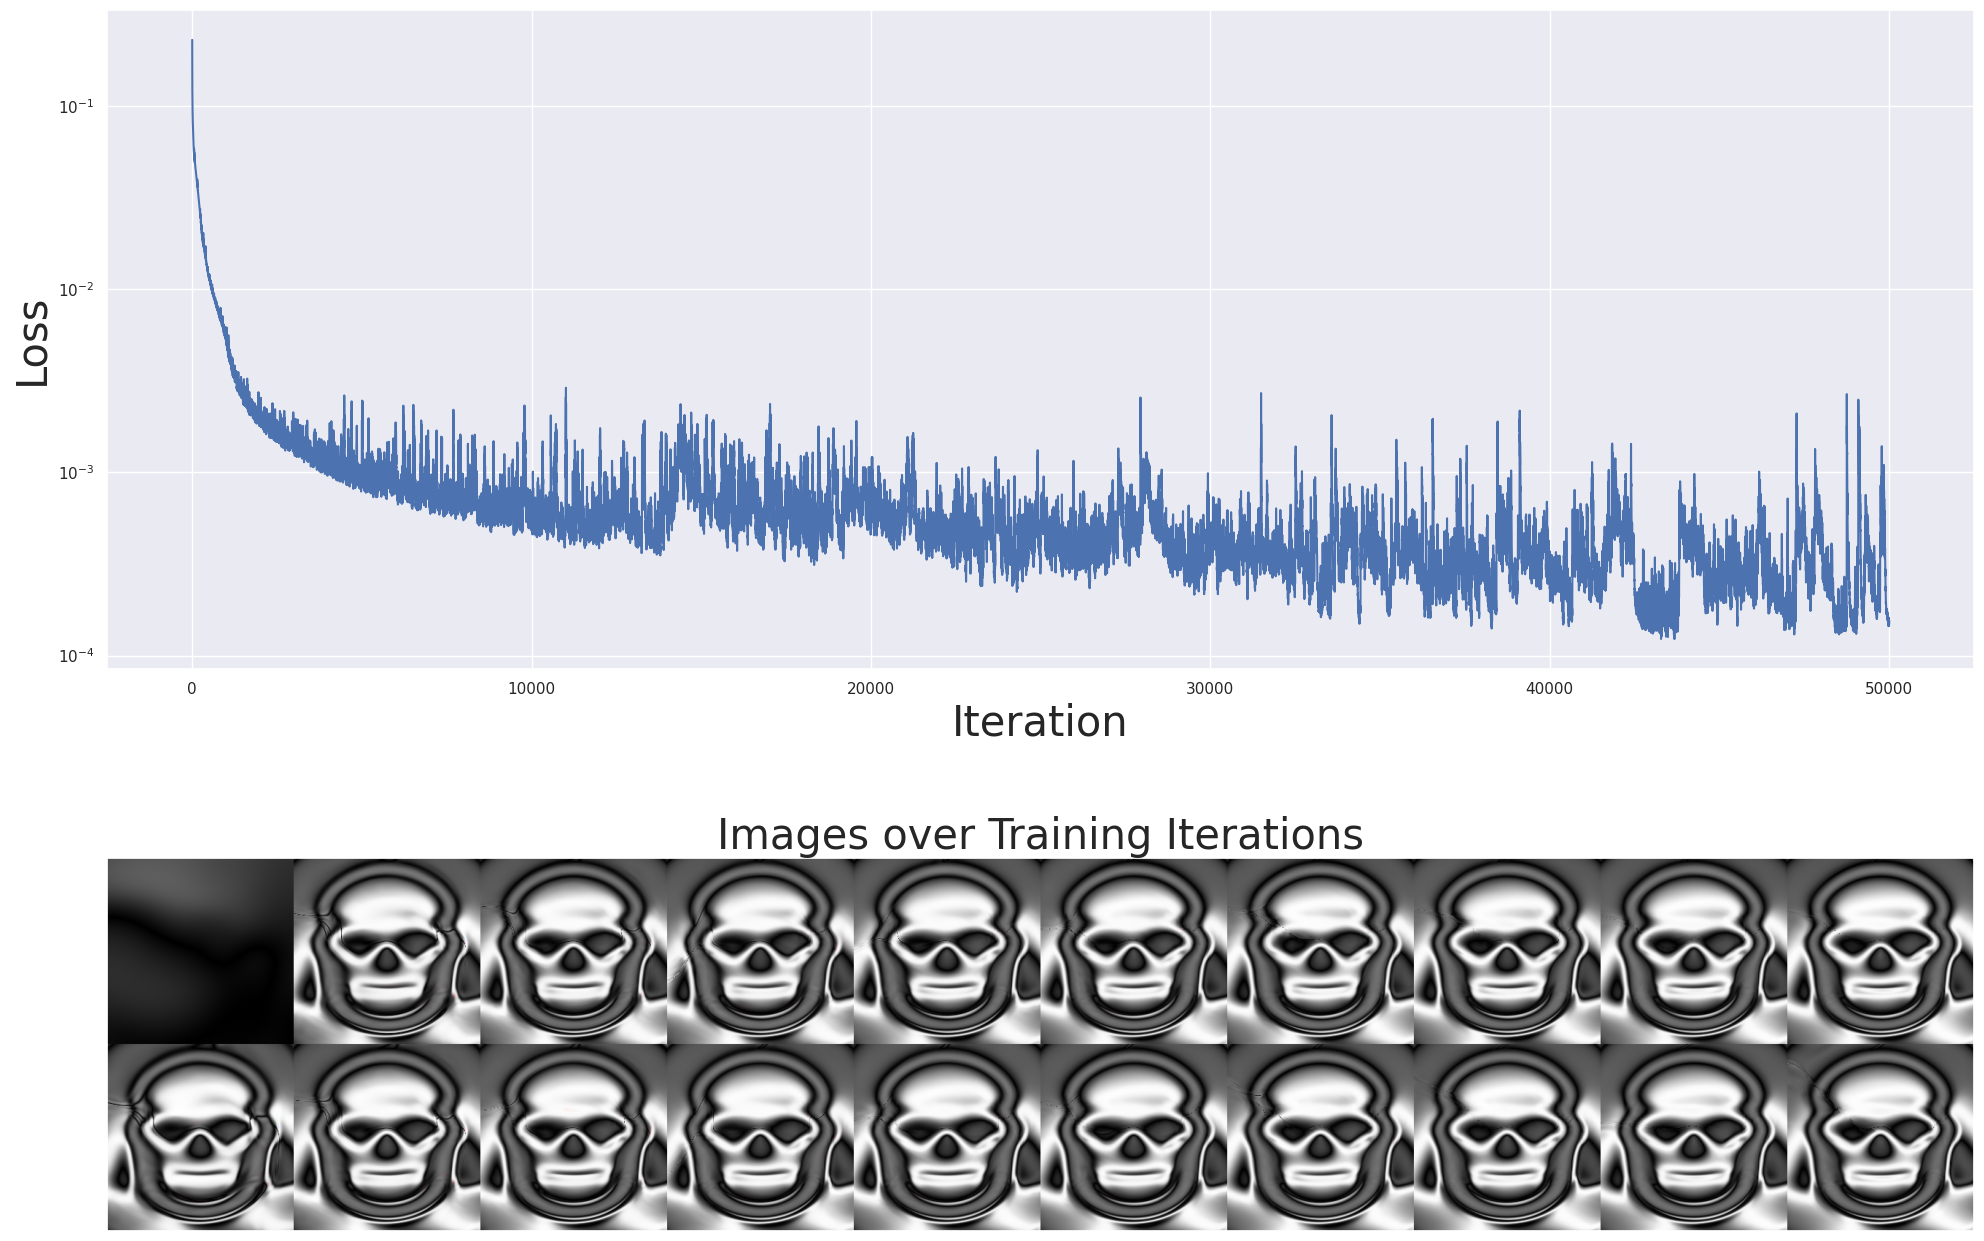

In [18]:
plt.figure(figsize=(20, 14))
plt.subplot(211)
plt.plot(losses)
plt.yscale('log')
plt.xlabel("Iteration", fontsize=30)
plt.ylabel("Loss", fontsize=30)

plt.subplot(212)
imgs = imgs_train[:-1]
imgs = imgs[::len(imgs)//20]
imgs = rearrange(imgs, "(C R) H W D -> (R H) (C W) D", R=2)
print(imgs.shape)
plt.imshow(imgs); plt.grid(False); plt.xticks([]); plt.yticks([])
plt.title("Images over Training Iterations", fontsize=30)

plt.tight_layout()
plt.show()


In [19]:
weight_sweep = jnp.linspace(-5, 5, 11)
gen_img_fn = jax.jit(jax.vmap(cppn.generate_image))

def get_variance(params, weight_id):
    params_p = repeat(params, "p -> n p", n=len(weight_sweep)).at[:, weight_id].set(weight_sweep)
    imgs = gen_img_fn(params_p)
    variance = jnp.var(imgs, axis=0).mean()
    return variance


In [20]:
%%time
variances = jax.lax.map(partial(get_variance, params), jnp.arange(0, len(params), 1), batch_size=20)

CPU times: user 6.78 s, sys: 5.95 s, total: 12.7 s
Wall time: 13 s


(6028,)


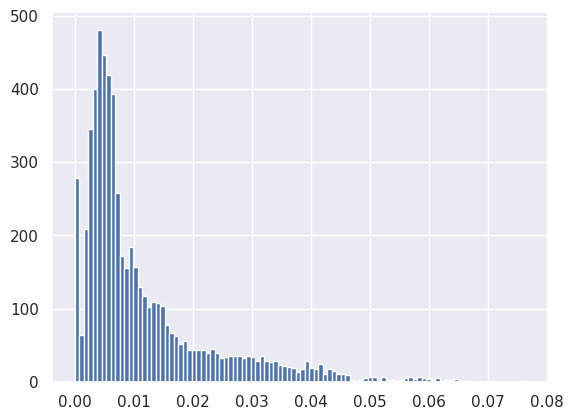

In [21]:
print(variances.shape)
plt.hist(np.array(variances), bins=100)
plt.show()

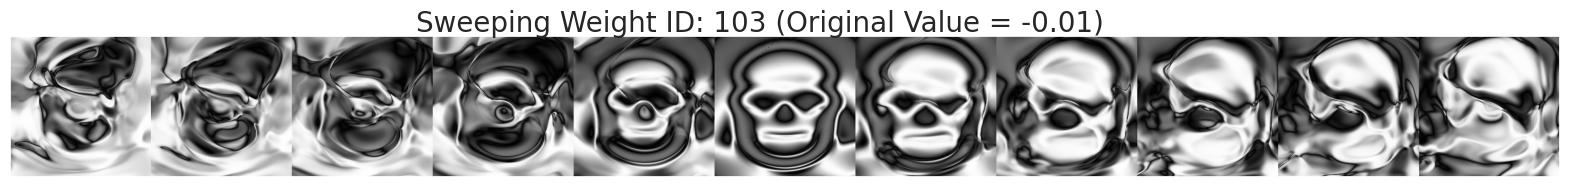

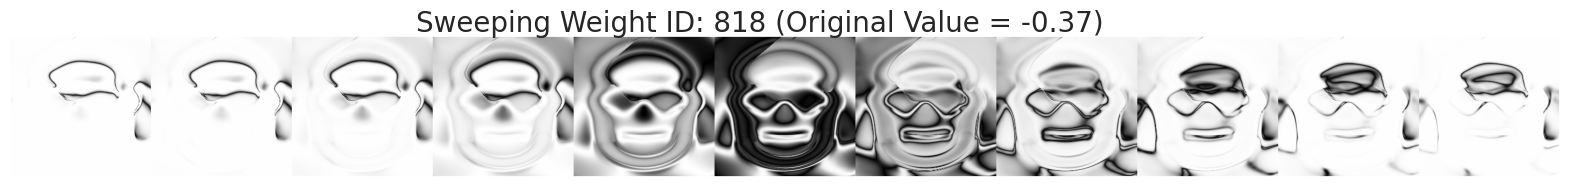

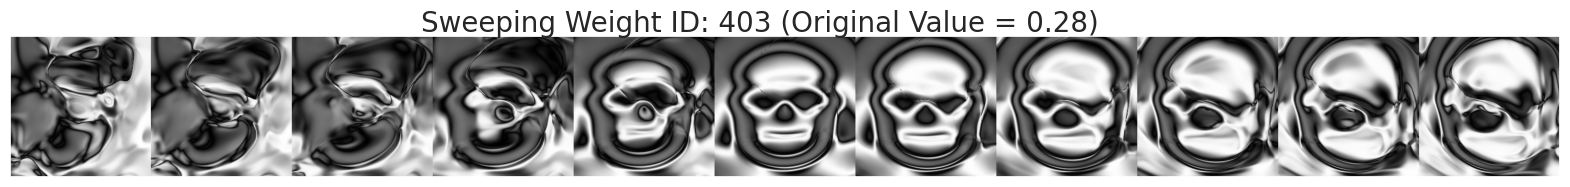

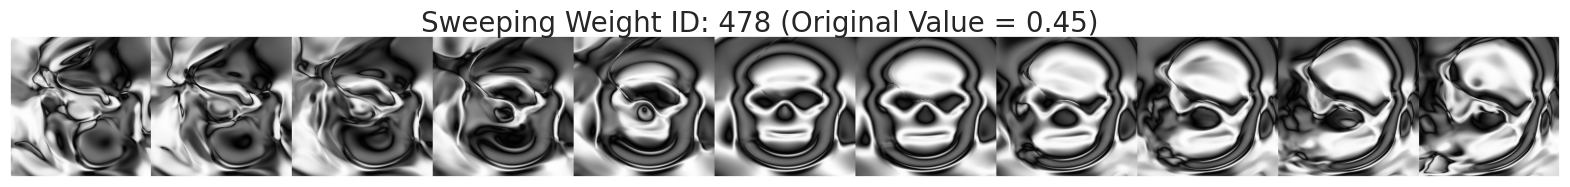

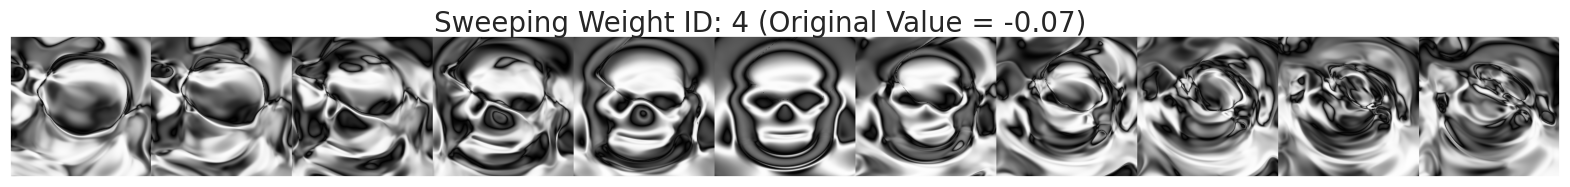

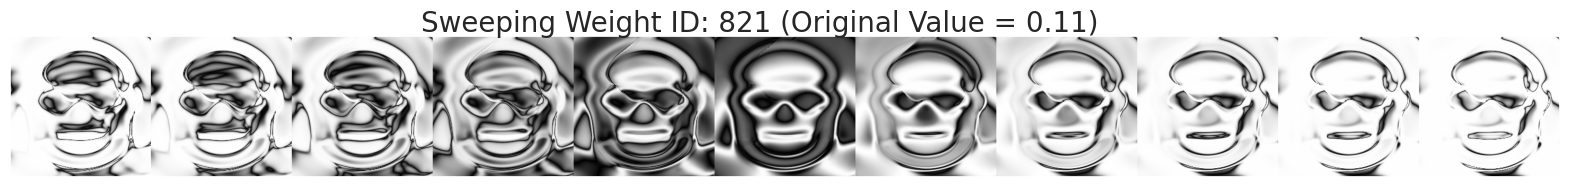

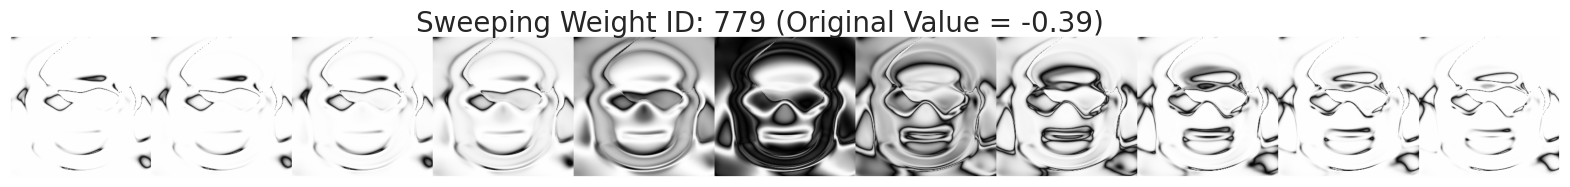

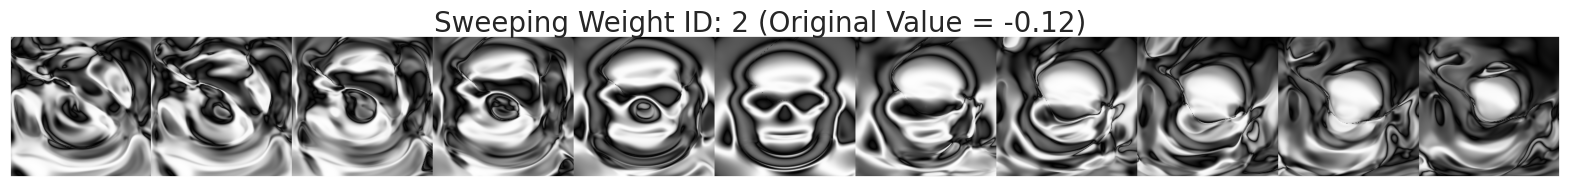

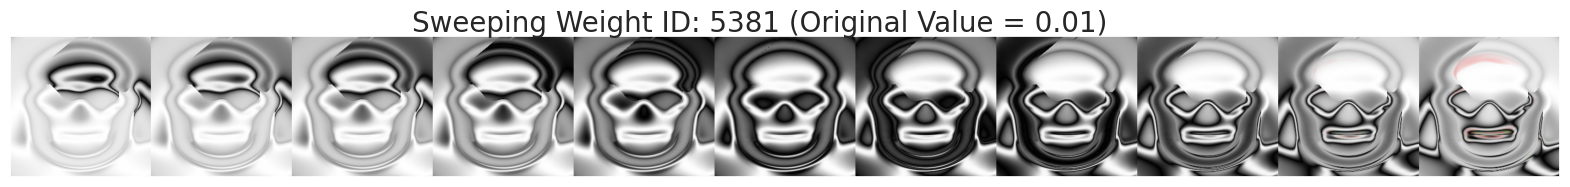

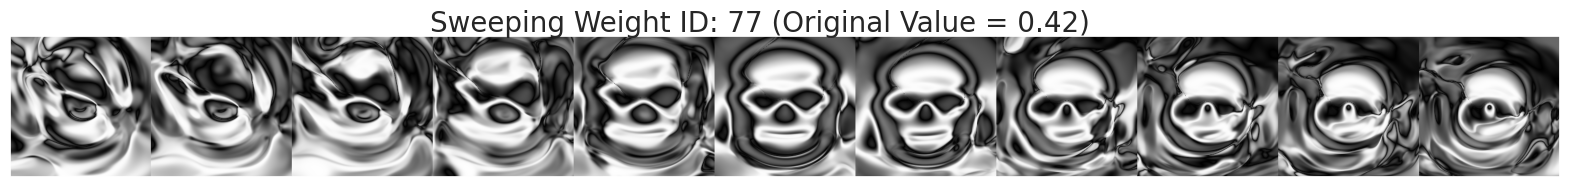

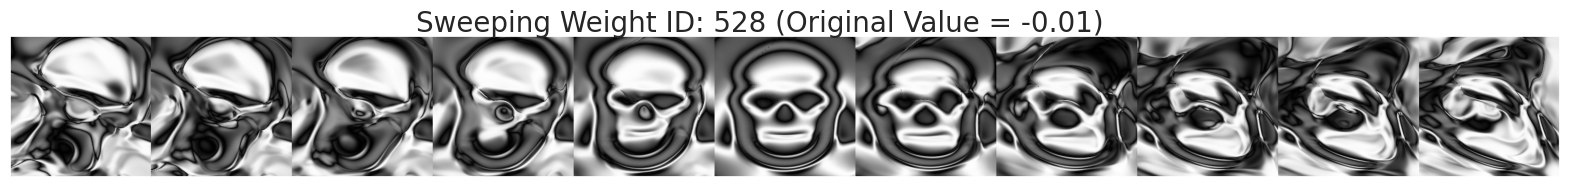

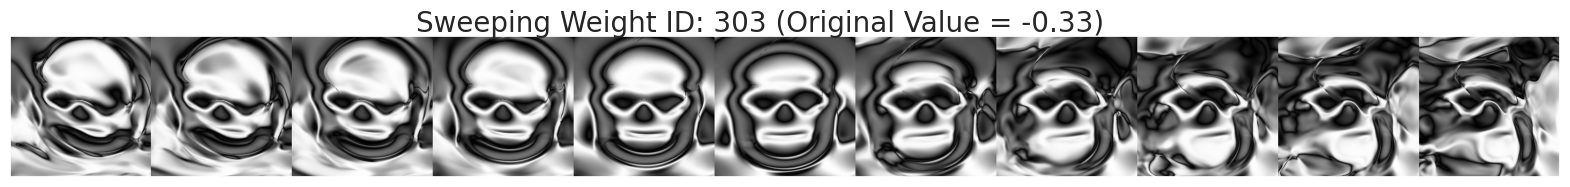

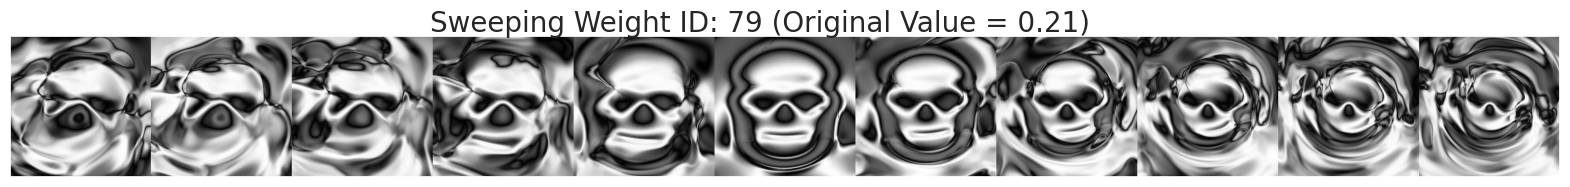

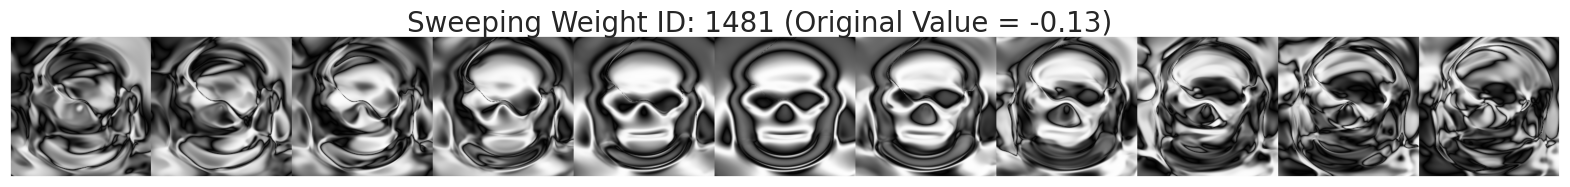

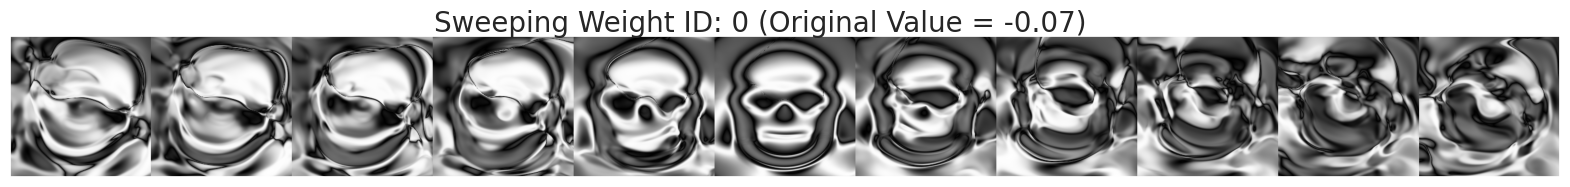

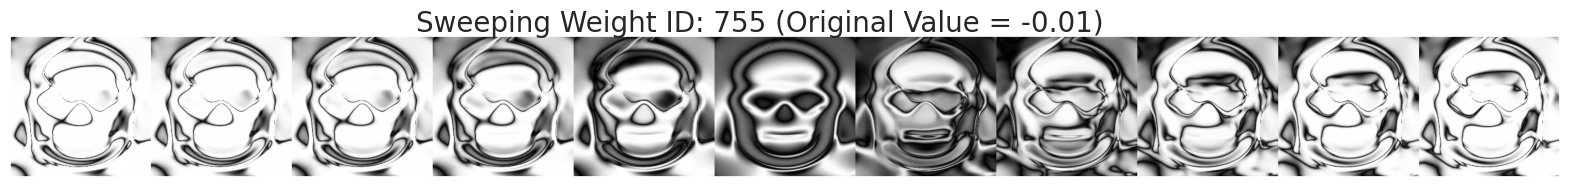

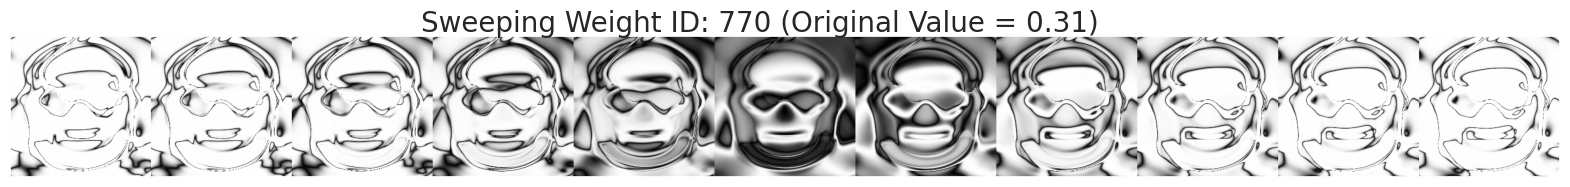

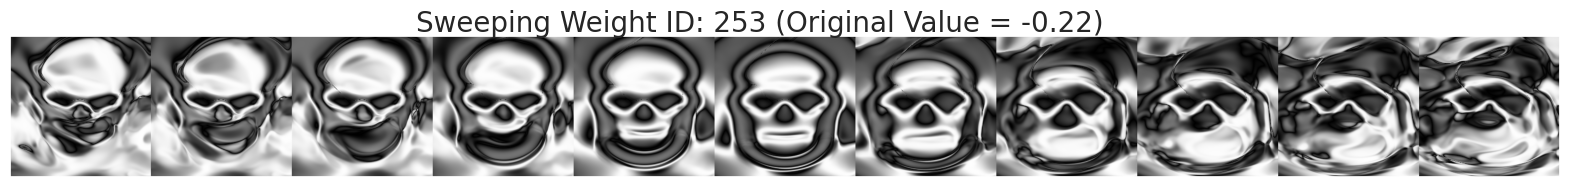

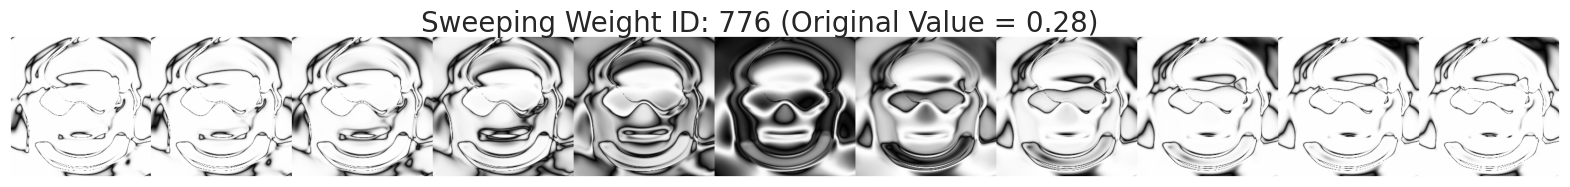

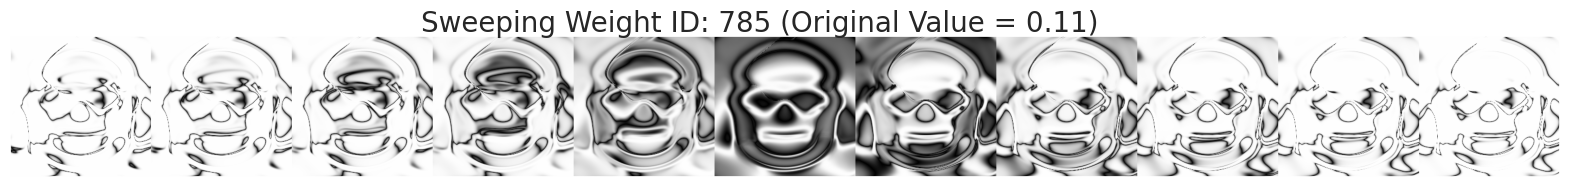

In [22]:
for weight_id in jnp.argsort(variances)[::-1][:20]:
    params_p = repeat(params, "p -> n p", n=11).at[:, weight_id].set(jnp.linspace(-5, 5, 11))
    imgs = gen_img_fn(params_p)
    imgs = rearrange(imgs, "n H W D -> H (n W) D")
    plt.figure(figsize=(20, 2))
    plt.imshow(imgs); plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.suptitle(f"Sweeping Weight ID: {weight_id.item()} (Original Value = {params[weight_id].item():.2f})", fontsize=20)
    plt.show()

In [75]:
# from matplotlib.colors import LinearSegmentedColormap
# cmap = LinearSegmentedColormap.from_list('red_white_blue', ['red', 'white', 'blue'])
def viz_feature_maps(img, features):
    max_features_per_layer = max(jax.tree.map(lambda x: x.shape[-1], features))
    n_layers = len(features)
    n_layers, max_features_per_layer

    plt.figure(figsize=(1*max_features_per_layer, 1*n_layers))
    for i, layer_features in enumerate(features):
        for j, fmap in enumerate(rearrange(layer_features, 'h w c -> c h w')):
            plt.subplot(n_layers, max_features_per_layer, i*max_features_per_layer + j + 1)
            plt.imshow(fmap, cmap='bwr_r', vmin=-1.0, vmax=1.0); plt.xticks([]); plt.yticks([])
            if j==0:
                plt.ylabel(f"{i}", fontsize=25)
            for spine in plt.gca().spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1)
    # plt.subplot(n_layers, max_features_per_layer, (n_layers-1)*max_features_per_layer + (max_features_per_layer-1) + 1)
    # plt.imshow(rgb); plt.axis('off')
    plt.gcf().supylabel("Layer", fontsize=35)
    plt.gcf().supxlabel("Feature Map", fontsize=35)
    plt.suptitle("Feature Maps of CPPN", fontsize=35)
    plt.tight_layout()
    return plt.gcf()

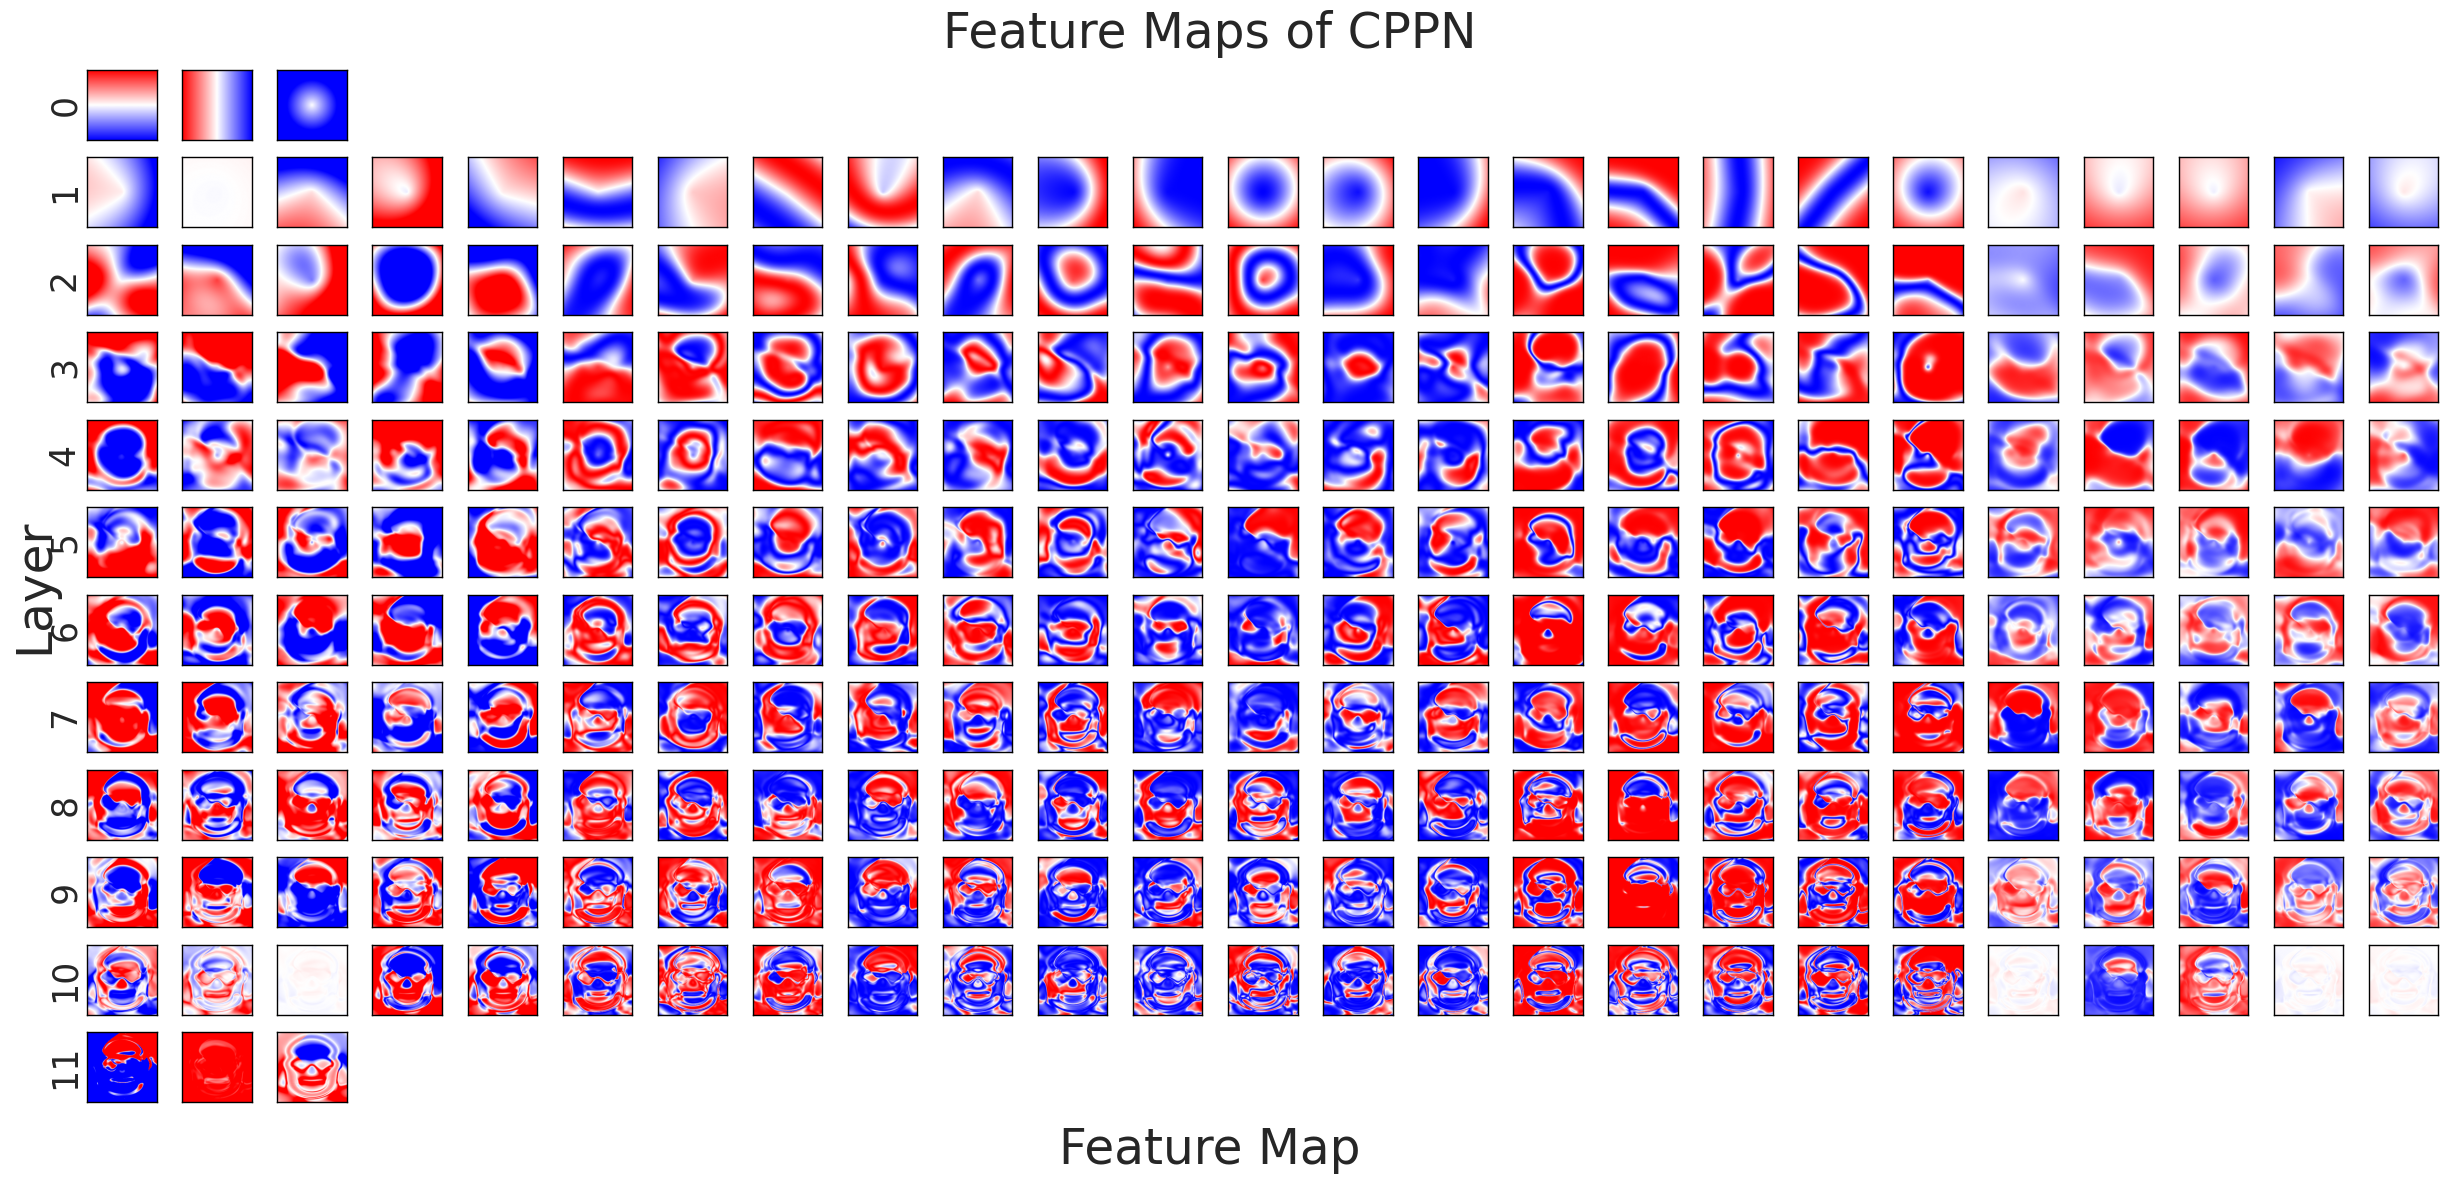

In [77]:
img, features = cppn.generate_image(params, return_features=True)
viz_feature_maps(img, features)
plt.show()

In [85]:
rng = jax.random.PRNGKey(3)
params_pb = jnp.zeros_like(params)
# params_pb = cppn.init(rng)
params_pb = cppn.param_reshaper.reshape_single(params_pb)

In [83]:
params_pb = cppn.param_reshaper.flatten_single(params_pb)

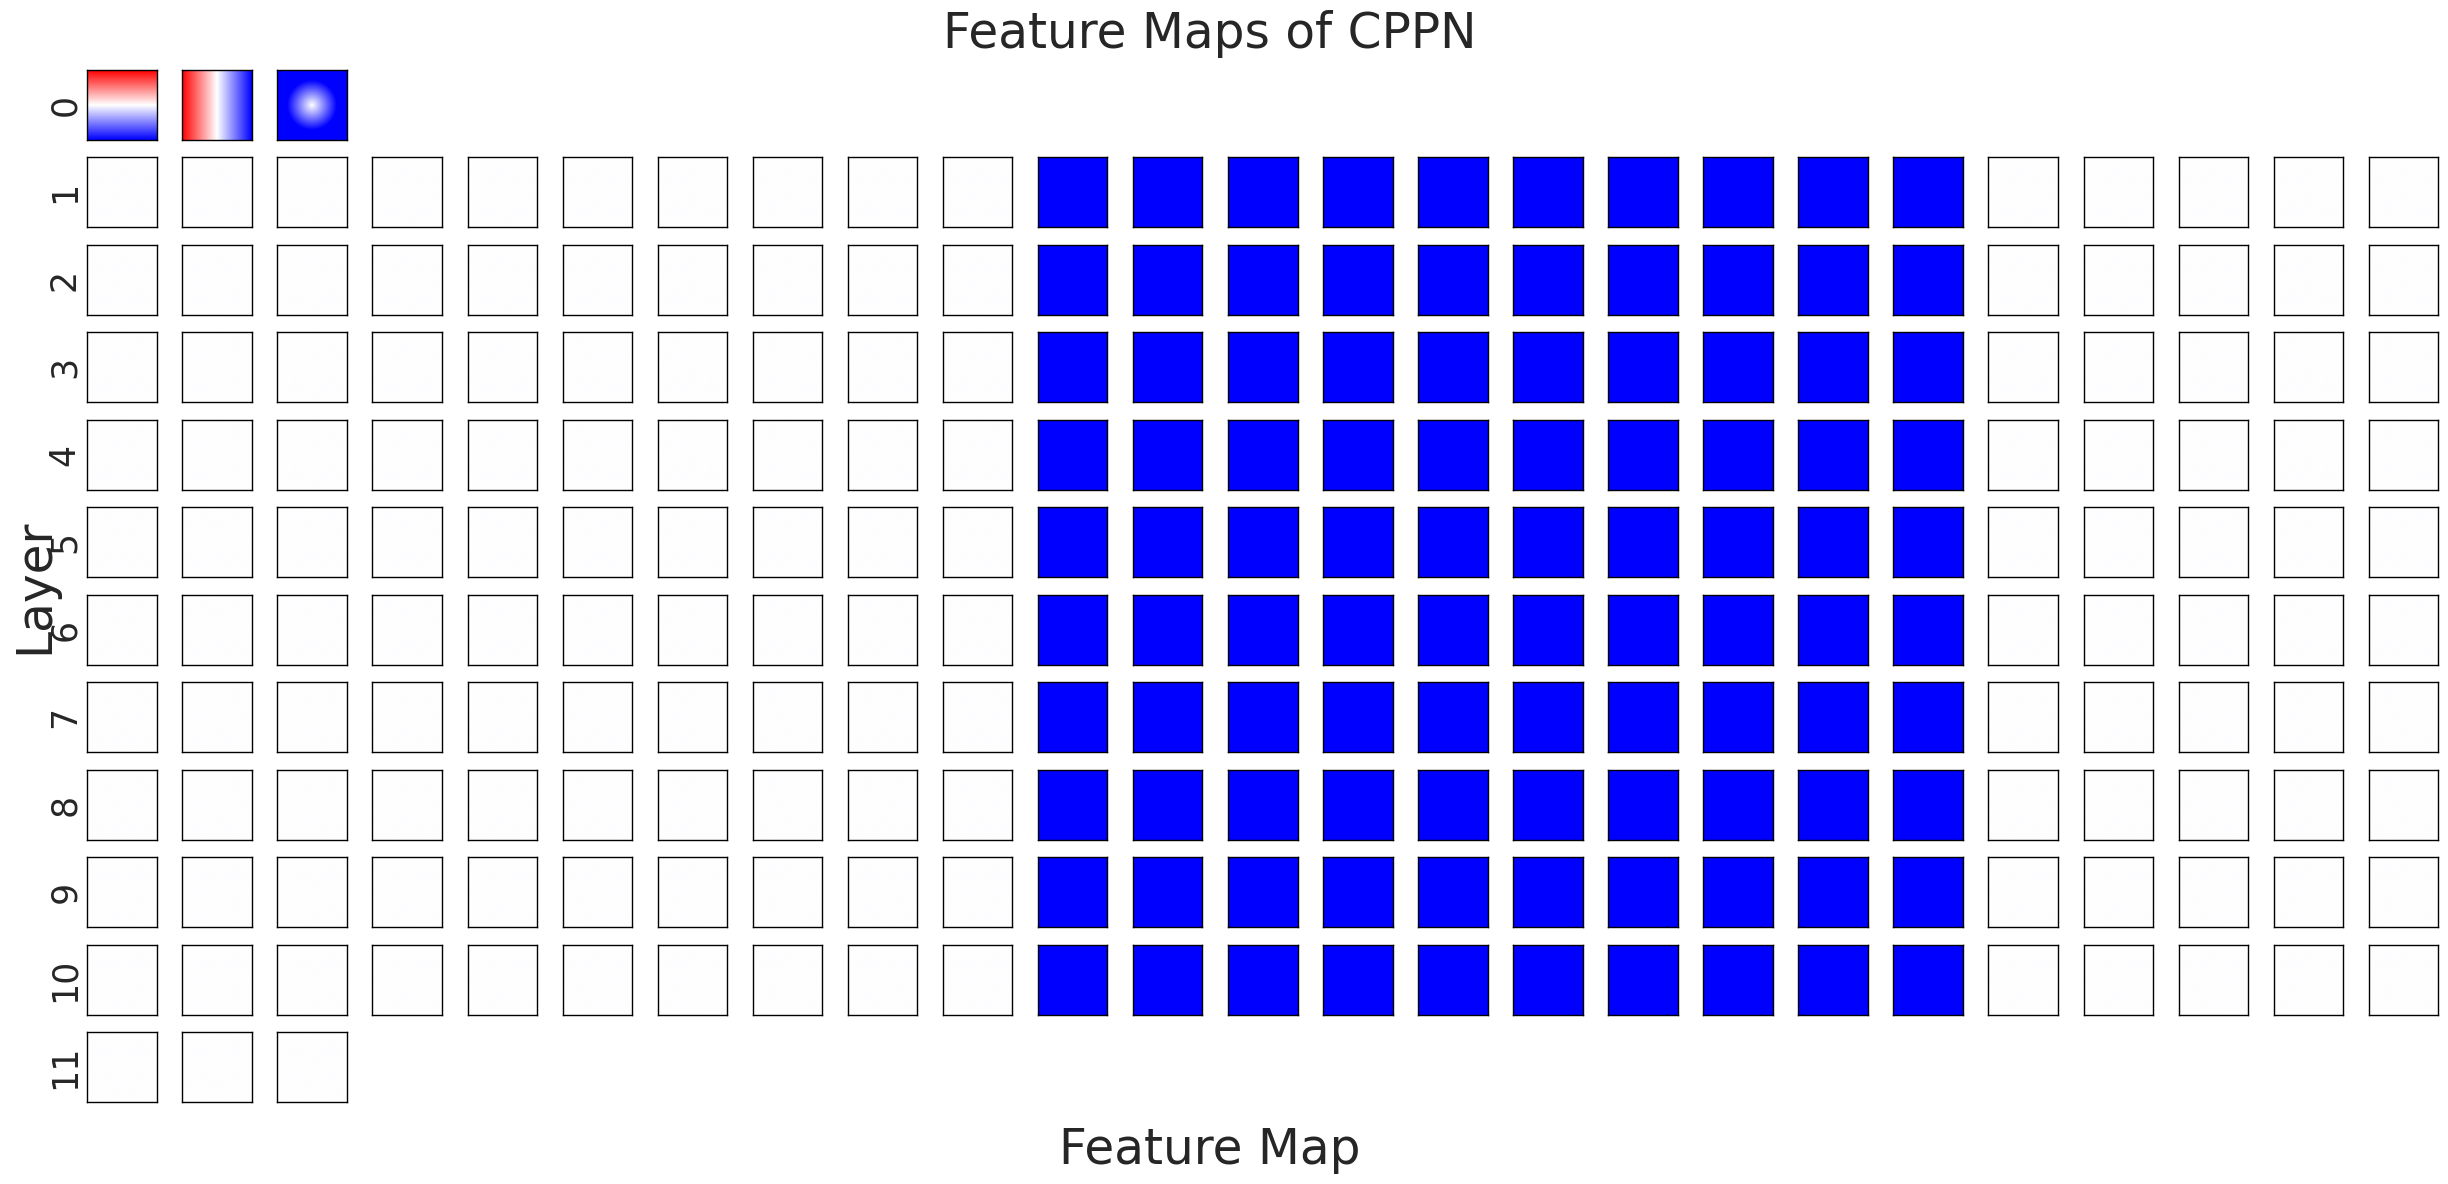

In [84]:
viz_feature_maps(*cppn.generate_image(params_pb, return_features=True))
plt.show()